# Feature Engineering 

In [1]:
import pandas as pd
import numpy as np
import math

from math import sqrt
import regex as re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler

import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textacy import preprocessing
import textacy
from nltk.corpus import stopwords
from nltk.stem import *

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from  sklearn.metrics  import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# for the Q-Q plots
import scipy.stats as stats


# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

## Imputing missing values
All missing values that are imputed in some way /mean, median, mode, other methods/ should be done separately for the training and the test set, in order to avoid data leakage.
Cardinality check, discretization and binning are taken into account

In [2]:
listings = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/listings.pkl')

In [3]:
listings.drop('id',axis=1,inplace=True)

In [4]:
# plot the histograms to have a quick look at the variable distribution
# histogram and Q-Q plots

def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

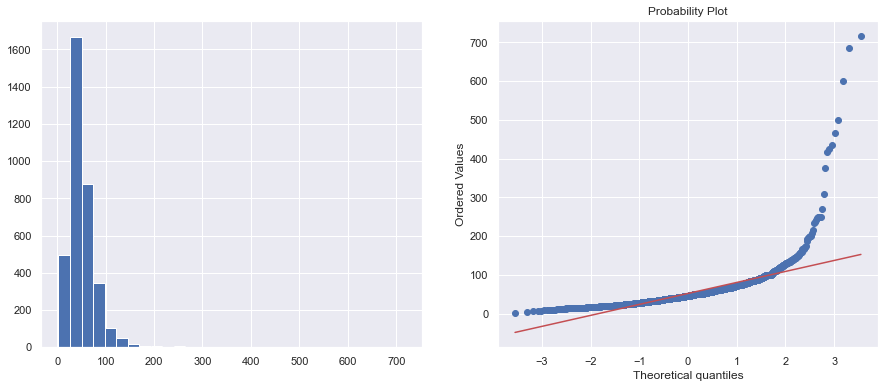

In [5]:
diagnostic_plots(listings,'price_per_person')

In [6]:
listings['price_per_person_log'] = np.log(listings['price_per_person'])

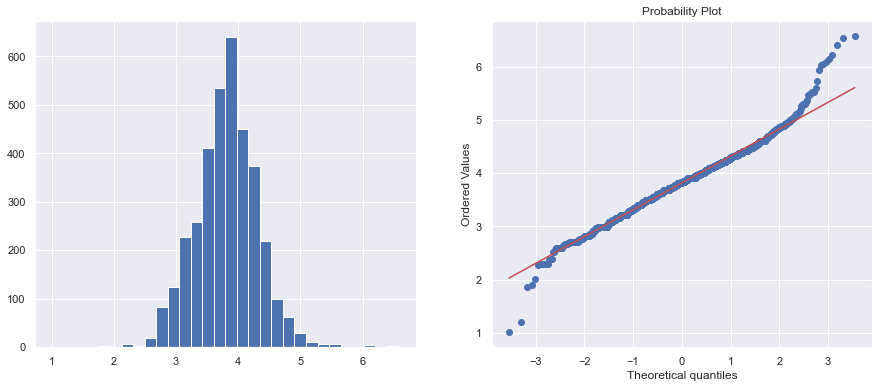

In [7]:
diagnostic_plots(listings,'price_per_person_log')

In [8]:
df = listings.drop(['price_per_person_log','price_per_person'],axis=1)
y = listings['price_per_person_log'].copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, # just the features
                                                    y, # the target
                                                    test_size=0.3, # the percentage of obs in the test set
                                                    random_state=42) # for reproducibility

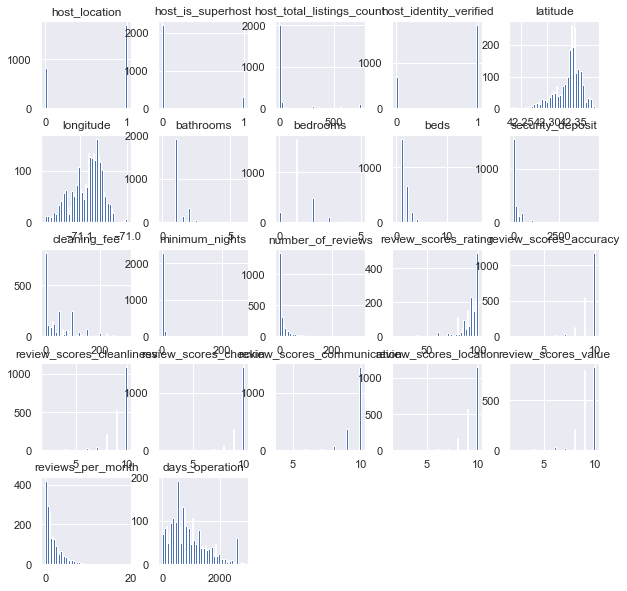

In [10]:
X_train.hist(bins=50, figsize=(10,10))
plt.show()

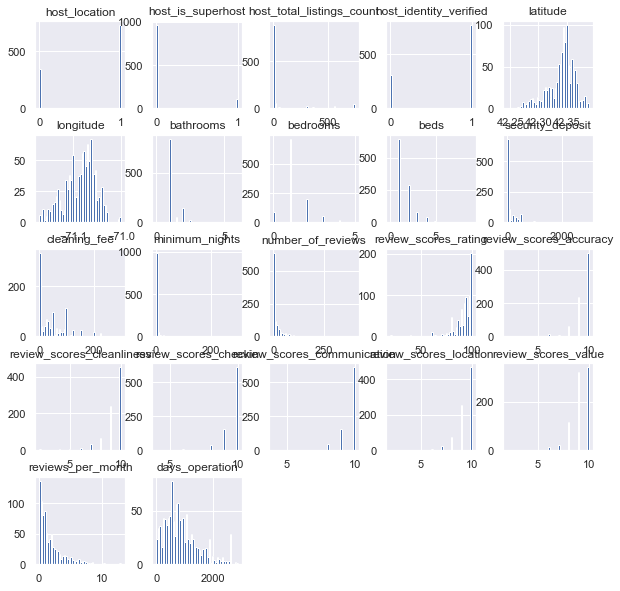

In [11]:
X_test.hist(bins=50, figsize=(10,10))
plt.show()

In [12]:
listings.isna().sum().sort_values(ascending = False)

review_scores_accuracy         823
review_scores_location         822
review_scores_value            821
review_scores_checkin          820
review_scores_cleanliness      818
review_scores_communication    818
review_scores_rating           813
reviews_per_month              756
host_response_time             471
host_acceptance_rate           471
host_response_rate             471
bathrooms                       14
bedrooms                        10
beds                             9
property_type                    3
city                             2
cancellation_policy              0
number_of_reviews                0
days_operation                   0
price_per_person                 0
host_location                    0
amenities                        0
minimum_nights                   0
cleaning_fee                     0
security_deposit                 0
bed_type                         0
room_type                        0
longitude                        0
latitude            

In [13]:
#We will use missing value category for the review columns NAs, since the proportion of the missing data is huge - 20% of the total dataset
missing_value = ['reviews_per_month','review_scores_location',
                          'review_scores_value','review_scores_checkin','review_scores_cleanliness',
                          'review_scores_communication','review_scores_rating','review_scores_accuracy',
                'host_response_time']

for col in missing_value:
    X_train[col].fillna(-1,inplace=True)
    X_test[col].fillna(-1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


#### Host response rate and acceptance rate also have around 10% of missing data -> it is quite. So I will use a missing category to impute for the missing values, and discretization&binning

In [14]:
cols = ['host_response_rate','host_acceptance_rate']
for col in cols:
    X_train[col] = X_train[col].str.replace('%','')
    X_train[col] = pd.to_numeric(X_train[col])
    X_test[col] = X_test[col].str.replace('%','')
    X_test[col] = pd.to_numeric(X_test[col])

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/3168245722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].str.replace('%','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/3168245722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.to_numeric(X_train[col])
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/3168245722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [15]:
X_train['host_response_rate'].fillna(-1,inplace=True)
X_train['host_acceptance_rate'].fillna(-1,inplace=True)

X_test['host_response_rate'].fillna(-1,inplace=True)
X_test['host_acceptance_rate'].fillna(-1,inplace=True)

In [16]:
# bucket boundaries
buckets = [-1, 0, 20, 40, 50, 70, 90,100]
X_train['response_rate_buckets'] = pd.cut(X_train['host_response_rate'], bins=buckets, include_lowest=True)
X_test['response_rate_buckets'] = pd.cut(X_test['host_response_rate'], bins=buckets, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/539011250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['response_rate_buckets'] = pd.cut(X_train['host_response_rate'], bins=buckets, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/539011250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['response_rate_buckets'] = pd.cut(X_test['host_response_rate'], bins=buckets, include_lowest=True)


In [17]:
# bucket 2 boundaries
buckets2 = [-1, 0, 20, 40, 50, 70, 90,100]
X_train['accept_rate_buckets'] = pd.cut(X_train['host_acceptance_rate'], bins=buckets, include_lowest=True)
X_test['accept_rate_buckets'] = pd.cut(X_test['host_acceptance_rate'], bins=buckets, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/2122951867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['accept_rate_buckets'] = pd.cut(X_train['host_acceptance_rate'], bins=buckets, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/2122951867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['accept_rate_buckets'] = pd.cut(X_test['host_acceptance_rate'], bins=buckets, include_lowest=True)


In [18]:
X_train['response_rate_buckets'].value_counts()

(90.0, 100.0]    1804
(-1.001, 0.0]     327
(70.0, 90.0]      286
(50.0, 70.0]       51
(20.0, 40.0]       19
(40.0, 50.0]       16
(0.0, 20.0]         6
Name: response_rate_buckets, dtype: int64

In [19]:
X_test['response_rate_buckets'].value_counts()

(90.0, 100.0]    764
(-1.001, 0.0]    157
(70.0, 90.0]     129
(50.0, 70.0]      16
(40.0, 50.0]       6
(0.0, 20.0]        2
(20.0, 40.0]       2
Name: response_rate_buckets, dtype: int64

In [20]:
X_train.drop(['host_response_rate','host_acceptance_rate'],axis=1,inplace=True)
X_test.drop(['host_response_rate','host_acceptance_rate'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Imputing numerical & categorical variables 

In [21]:
# Imputing with median value - Based on the nature of the variables, as well as on their distribution, we are choosing what to impute with: variables with more close to normal distribution - mean; skewed variables - median
numeric_features_median = ['bathrooms','bedrooms','beds','days_operation']

for col in numeric_features_median:
    X_train[col].fillna(X_train[col].median(),inplace=True)
    X_test[col].fillna(X_test[col].median(),inplace=True)

In [22]:
#impute with mode for the categorical features
cat_features_mode = ['property_type','city']

for col in cat_features_mode:
    most = X_train[col].mode().values[0]
    X_train[col].fillna(most,inplace=True)
    most2 = X_test[col].mode().values[0]
    X_test[col].fillna(most2,inplace=True)

In [23]:
X_train.isna().sum()

host_location                  0
host_response_time             0
host_is_superhost              0
host_total_listings_count      0
host_identity_verified         0
neighbourhood_cleansed         0
city                           0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
amenities                      0
security_deposit               0
cleaning_fee                   0
minimum_nights                 0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
cancellation_policy            0
reviews_per_month              0
days_operation                 0
response_r

### Additional discretization of host_total_listings_count, days_operation and minimum_nights

In [25]:
X_train['host_total_listings_count'].max()

749

In [32]:
#The host needs to have at least 1 property
X_train.loc[X_train['host_total_listings_count']==0,'host_total_listings_count']=1
X_test.loc[X_test['host_total_listings_count']==0,'host_total_listings_count']=1

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [33]:
# buckets for host listings
buckets_host = [1,2,3,1000]
X_train['host_listings'] = pd.cut(X_train['host_total_listings_count'], bins=buckets_host, include_lowest=True)
X_test['host_listings'] = pd.cut(X_test['host_total_listings_count'], bins=buckets_host, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1216118954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['host_listings'] = pd.cut(X_train['host_total_listings_count'], bins=buckets_host, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1216118954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['host_listings'] = pd.cut(X_test['host_total_listings_count'], bins=buckets_host, include_lowest=True)


In [34]:
buckets_nights = [1,2,3,1000]
X_train['min_nights'] = pd.cut(X_train['minimum_nights'], bins=buckets_nights, include_lowest=True)
X_test['min_nights'] = pd.cut(X_test['minimum_nights'], bins=buckets_nights, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1755257232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['min_nights'] = pd.cut(X_train['minimum_nights'], bins=buckets_nights, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1755257232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['min_nights'] = pd.cut(X_test['minimum_nights'], bins=buckets_nights, include_lowest=True)


In [35]:
X_train['days_operation'].max()

2857

In [40]:
buckets_days = [1,180,365,730,1095,5000]
X_train['days_oper'] = pd.cut(X_train['days_operation'], bins=buckets_days, include_lowest=True)
X_test['days_oper'] = pd.cut(X_test['days_operation'], bins=buckets_days, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1168726190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['days_oper'] = pd.cut(X_train['days_operation'], bins=buckets_days, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1168726190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['days_oper'] = pd.cut(X_test['days_operation'], bins=buckets_days, include_lowest=True)


In [41]:
X_train['days_oper'].value_counts()

(1095.0, 5000.0]    773
(365.0, 730.0]      696
(730.0, 1095.0]     544
(180.0, 365.0]      250
(0.999, 180.0]      246
Name: days_oper, dtype: int64

In [42]:
X_train.shape

(2509, 35)

In [43]:
X_test.shape

(1076, 35)

#### Cardinality check

In [44]:
X_train['host_response_time'].value_counts()

within an hour        961
within a few hours    867
within a day          328
-1                    317
a few days or more     36
Name: host_response_time, dtype: int64

In [45]:
X_test['host_response_time'].value_counts()

within an hour        423
within a few hours    351
-1                    154
within a day          141
a few days or more      7
Name: host_response_time, dtype: int64

In [46]:
X_train['city'].value_counts()

Boston                       2369
Roxbury Crossing               16
Brookline                      13
Jamaica Plain                  12
Cambridge                      11
Brighton                       11
Somerville                     11
Dorchester                     11
Charlestown                    10
Allston                         9
Roslindale                      4
East Boston                     3
Mattapan                        3
ALLSTON                         2
West Roxbury                    2
Boston, Massachusetts, US       2
ROXBURY CROSSING                2
Jamaica Plain                   2
dorchester, boston              1
Mission Hill, Boston            1
South Boston                    1
Roslindale, Boston              1
Brighton                        1
Jamaica Plain, Boston           1
Jamaica plain                   1
Jamaica Plain (Boston)          1
Boston (Jamaica Plain)          1
Watertown                       1
Newton                          1
boston        

In [47]:
#THe prevailing value was Boston, so we marked the city with 1 for Boston, and 0 for the rest
X_train['city']=np.where(X_train['city']=='Boston',1,0)
X_test['city']=np.where(X_test['city']=='Boston',1,0)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1657766666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['city']=np.where(X_train['city']=='Boston',1,0)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/1657766666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['city']=np.where(X_test['city']=='Boston',1,0)


#### Categorical handling of аmenities

In [48]:
def text_cleaner_open_amenities(serie, words= []):
    '''
    input: pandas series, stop words
    ouput: removes special char, stop words, symbols.'''
    serie = serie.astype(str).str.lower()
    #st = PorterStemmer()
    stop= stopwords.words('english') + words
    stop = [x for x in stop]
    
    serie=serie.str.replace('"','')
    serie=serie.str.replace('{','')
    serie=serie.str.replace('}','')
    serie= serie.apply(lambda x: " ".join([word for word in x.split() 
                                           if word not in stop])) 
    return serie

In [49]:
X_train['amenities'] = text_cleaner_open_amenities(X_train['amenities'])
X_test['amenities'] = text_cleaner_open_amenities(X_test['amenities'])

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/4007061188.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  serie=serie.str.replace('{','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/4007061188.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  serie=serie.str.replace('}','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_20794/4267831456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [50]:
vectorizer_am = CountVectorizer(tokenizer=lambda x: x.split(','))
vectorizer_am.fit(X_train['amenities'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(tokenizer=<function <lambda> at 0x7f86cc0cc8b0>)

In [51]:
vectorizer_am.get_feature_names()

['',
 '24-hour check-in',
 'air conditioning',
 'breakfast',
 'buzzer/wireless intercom',
 'cable tv',
 'carbon monoxide detector',
 'cat(s)',
 'dog(s)',
 'doorman',
 'dryer',
 'elevator building',
 'essentials',
 'family/kid friendly',
 'fire extinguisher',
 'first aid kit',
 'free parking premises',
 'free parking street',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'hot tub',
 'indoor fireplace',
 'internet',
 'iron',
 'kitchen',
 'laptop friendly workspace',
 'lock bedroom door',
 'other pet(s)',
 'paid parking premises',
 'pets allowed',
 'pets live property',
 'pool',
 'safety card',
 'shampoo',
 'smoke detector',
 'smoking allowed',
 'suitable events',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'tv',
 'washer',
 'washer / dryer',
 'wheelchair accessible',
 'wireless internet']

In [52]:
dt = vectorizer_am.transform(X_train['amenities'])

In [53]:
dt.shape

(2509, 46)

In [54]:
X_train = X_train.join(pd.DataFrame(dt.toarray(), columns=vectorizer_am.get_feature_names(), index= X_train.index))

In [55]:
X_train.shape

(2509, 81)

In [56]:
dt1 = vectorizer_am.transform(X_test['amenities'])

In [57]:
X_test = X_test.join(pd.DataFrame(dt1.toarray(), columns=vectorizer_am.get_feature_names(), index= X_test.index))

In [58]:
X_test.shape

(1076, 81)

In [59]:
#combine some of the features
X_train.loc[X_train['wireless internet']==1,'internet']=1
X_test.loc[X_test['wireless internet']==1,'internet']=1

In [60]:
X_train.loc[X_train['tv']==1,'cable tv']=1
X_test.loc[X_test['tv']==1,'cable tv']=1

In [61]:
X_train.loc[X_train['washer / dryer']==1,'washer']=1
X_train.loc[X_train['washer / dryer']==1,'dryer']=1

X_test.loc[X_test['washer / dryer']==1,'washer']=1
X_test.loc[X_test['washer / dryer']==1,'dryer']=1

In [62]:
X_train.drop(['','translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50','wireless internet','tv','washer / dryer'],axis=1,inplace=True)

In [63]:
X_test.drop(['','translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50','wireless internet','tv','washer / dryer'],axis=1,inplace=True)

In [64]:
X_train.shape

(2509, 75)

In [65]:
X_test.shape

(1076, 75)

In [66]:
X_train.drop(columns={'host_total_listings_count','minimum_nights','days_operation'},axis=1,inplace=True)
X_test.drop(columns={'host_total_listings_count','minimum_nights','days_operation'},axis=1,inplace=True)

### Outliers
The outliers should be removed from the training set. We are treating the test set as not seen before, so outliers are not to be evaluated and removed from there. 

In [67]:
def find_skewed_boundaries(df, variable, distance):

    # Function to find the outliers 
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [68]:
train = X_train.join(y_train)

In [69]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(train, 'price_per_person_log', 1.5)
RM_upper_limit, RM_lower_limit

(5.098149977499359, 2.551442641211821)

In [70]:
train['outliers_price'] = np.where(train['price_per_person_log'] > RM_upper_limit, True,
                       np.where(train['price_per_person_log'] < RM_lower_limit, True, False))

In [71]:
train['outliers_price'].value_counts()

False    2475
True       34
Name: outliers_price, dtype: int64

In [72]:
34/2509

0.013551215623754484

The outliers by price are 4% of the total data, so we can just remove them.

In [73]:
train = train[train['outliers_price']==False]

In [74]:
train.head()

,host_location,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,amenities,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,response_rate_buckets,accept_rate_buckets,host_listings,min_nights,days_oper,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible,price_per_person_log,outliers_price
2609,1,within a few hours,0,0,Brighton,1,42.337190,-71.151437,Condominium,Entire home/apt,1.0,1.0,3.0,Futon,"internet,wireless internet,air conditioning,ki...",0.0,30.0,16,89.0,8.0,9.0,10.0,10.0,9.0,9.0,moderate,0.40,"(90.0, 100.0]","(70.0, 90.0]","(0.999, 2.0]","(0.999, 2.0]","(1095.0, 5000.0]",1,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,4.180216,False
2014,1,within a day,0,1,Beacon Hill,1,42.357559,-71.071720,Apartment,Entire home/apt,1.0,1.0,1.0,Real Bed,"tv,cable tv,internet,wireless internet,air con...",500.0,100.0,9,89.0,10.0,9.0,9.0,9.0,10.0,9.0,strict,0.92,"(90.0, 100.0]","(50.0, 70.0]","(3.0, 1000.0]","(0.999, 2.0]","(1095.0, 5000.0]",0,1,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3.824284,False
407,0,within a day,0,0,Mission Hill,1,42.328580,-71.098055,Apartment,Private room,2.0,1.0,1.0,Real Bed,"tv,cable tv,internet,wireless internet,air con...",0.0,35.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,strict,-1.00,"(90.0, 100.0]","(90.0, 100.0]","(0.999, 2.0]","(0.999, 2.0]","(730.0, 1095.0]",0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3.028683,False
1188,1,within an hour,0,1,South End,1,42.344141,-71.072263,Apartment,Entire home/apt,1.0,2.0,1.0,Real Bed,"tv,cable tv,internet,wireless internet,air con...",250.0,65.0,6,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,0.37,"(90.0, 100.0]","(40.0, 50.0]","(0.999, 2.0]","(0.999, 2.0]","(365.0, 730.0]",0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,4.199755,False
1084,0,within a few hours,0,1,South End,1,42.345003,-71.077470,Apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,"tv,cable tv,wireless internet,air conditioning...",0.0,225.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,strict,-1.00,"(90.0, 100.0]","(90.0, 100.0]","(3.0, 1000.0]","(3.0, 1000.0]","(365.0, 730.0]",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.821442,False


In [75]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(train, 'cleaning_fee', 1.5)
RM_upper_limit, RM_lower_limit

(200.0, -120.0)

__The security deposit outliers are exceeding 10% of the data -> we are expecting distortion from there. __

In [76]:
train.drop(['amenities','outliers_price'],axis=1,inplace=True)

In [77]:
X_test.drop(['amenities'],axis=1,inplace=True)

In [78]:
train['beds'].value_counts()

1.0     1503
2.0      662
3.0      189
4.0       67
5.0       27
6.0       11
7.0        7
8.0        5
0.0        2
9.0        1
16.0       1
Name: beds, dtype: int64

In [79]:
X_train = train.drop('price_per_person_log',axis=1)
y_train = train['price_per_person_log'].copy()

In [80]:
X_train.shape

(2475, 71)

In [81]:
y_train.shape

(2475,)

In [82]:
X_train.head()

,host_location,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,response_rate_buckets,accept_rate_buckets,host_listings,min_nights,days_oper,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible
2609,1,within a few hours,0,0,Brighton,1,42.337190,-71.151437,Condominium,Entire home/apt,1.0,1.0,3.0,Futon,0.0,30.0,16,89.0,8.0,9.0,10.0,10.0,9.0,9.0,moderate,0.40,"(90.0, 100.0]","(70.0, 90.0]","(0.999, 2.0]","(0.999, 2.0]","(1095.0, 5000.0]",1,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0
2014,1,within a day,0,1,Beacon Hill,1,42.357559,-71.071720,Apartment,Entire home/apt,1.0,1.0,1.0,Real Bed,500.0,100.0,9,89.0,10.0,9.0,9.0,9.0,10.0,9.0,strict,0.92,"(90.0, 100.0]","(50.0, 70.0]","(3.0, 1000.0]","(0.999, 2.0]","(1095.0, 5000.0]",0,1,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
407,0,within a day,0,0,Mission Hill,1,42.328580,-71.098055,Apartment,Private room,2.0,1.0,1.0,Real Bed,0.0,35.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,strict,-1.00,"(90.0, 100.0]","(90.0, 100.0]","(0.999, 2.0]","(0.999, 2.0]","(730.0, 1095.0]",0,1,0,1,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1188,1,within an hour,0,1,South End,1,42.344141,-71.072263,Apartment,Entire home/apt,1.0,2.0,1.0,Real Bed,250.0,65.0,6,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict,0.37,"(90.0, 100.0]","(40.0, 50.0]","(0.999, 2.0]","(0.999, 2.0]","(365.0, 730.0]",0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0
1084,0,within a few hours,0,1,South End,1,42.345003,-71.077470,Apartment,Entire home/apt,1.0,0.0,1.0,Real Bed,0.0,225.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,strict,-1.00,"(90.0, 100.0]","(90.0, 100.0]","(3.0, 1000.0]","(3.0, 1000.0]","(365.0, 730.0]",0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### One-hot encoding of categorical variables

I use the one hot encoder from the feature engine, because it is clear, can point the variables, as well as returns back a datarame. 
__For Linear regression model - encode into K-1 variables<br>
For tree models - encode into K variables, since with the ensemble methods we are not using all features__
I am using the One-hot encoder from the feature engine, since it directly returns a dataframe w/o the original variable, with the respective names etc.

In [83]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 2609 to 3174
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   host_location                2475 non-null   int64   
 1   host_response_time           2475 non-null   object  
 2   host_is_superhost            2475 non-null   int64   
 3   host_identity_verified       2475 non-null   int64   
 4   neighbourhood_cleansed       2475 non-null   object  
 5   city                         2475 non-null   int64   
 6   latitude                     2475 non-null   float64 
 7   longitude                    2475 non-null   float64 
 8   property_type                2475 non-null   object  
 9   room_type                    2475 non-null   object  
 10  bathrooms                    2475 non-null   float64 
 11  bedrooms                     2475 non-null   float64 
 12  beds                         2475 non-null   float64 
 13  

In [84]:
X_train.describe(include='object').transpose()

,count,unique,top,freq
host_response_time,2475,5,within an hour,952
neighbourhood_cleansed,2475,25,South End,223
property_type,2475,10,Apartment,1819
room_type,2475,3,Entire home/apt,1463
bed_type,2475,5,Real Bed,2378
cancellation_policy,2475,4,strict,1106


In [92]:
X_train.describe(include='category').transpose()

,count,unique,top,freq
response_rate_buckets,2475,7,"(90.0, 100.0]",1789
accept_rate_buckets,2475,7,"(90.0, 100.0]",1311
host_listings,2475,3,"(0.999, 2.0]",1440
min_nights,2475,3,"(0.999, 2.0]",1671
days_oper,2475,5,"(1095.0, 5000.0]",769


In [93]:
ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    variables=['host_response_time','neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy','response_rate_buckets','accept_rate_buckets','host_listings','min_nights','days_oper'],  # we can select which variables to encode
    drop_last=False)  # to return k-1, false to return k

ohe_enc.fit(X_train)

OneHotEncoder(variables=['host_response_time', 'neighbourhood_cleansed',
                         'property_type', 'room_type', 'bed_type',
                         'cancellation_policy', 'response_rate_buckets',
                         'accept_rate_buckets', 'host_listings', 'min_nights',
                         'days_oper'])

In [94]:
X_train_tr = ohe_enc.transform(X_train)

X_train_tr.head()

,host_location,host_is_superhost,host_identity_verified,city,latitude,longitude,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible,host_response_time_within a few hours,host_response_time_within a day,host_response_time_within an hour,host_response_time_-1,host_response_time_a few days or more,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_South End,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_West Roxbury,neighbourhood_cleansed_West End,neighbourhood_cleansed_North End,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Roslindale,property_type_Condominium,property_type_Apartment,property_type_House,property_type_Bed & Breakfast,property_type_Other,property_type_Townhouse,property_type_Loft,property_type_Boat,property_type_Villa,property_type_Entire Floor,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Futon,bed_type_Real Bed,bed_type_Pull-out Sofa,bed_type_Airbed,bed_type_Couch,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_flexible,cancellation_policy_super_strict_30,"response_rate_buckets_(90.0, 100.0]","response_rate_buckets_(40.0, 50.0]","response_rate_buckets_(70.0, 90.0]","response_rate_buckets_(-1.001, 0.0]","response_rate_buckets_(50.0, 70.0]","response_rate_buckets_(0.0, 20.0]","response_rate_buckets_(20.0, 40.0]","accept_rate_buckets_(70.0, 90.0]","accept_rate_buckets_(50.0, 70.0]","accept_rate_buckets_(90.0, 100.0]","accept_rate_buckets_(40.0, 50.0]","accept_rate_buckets_(20.0, 40.0]","accept_rate_buckets_(-1.001, 0.0]","accept_rate_buckets_(0.0, 20.0]","host_listings_(0.999, 2.0]","host_listings_(3.0, 1000.0]","host_listings_(2.0, 3.0]","min_nights_(0.999, 2.0]","min_nights_(3.0, 1000.0]","min_nights_(2.0, 3.0]","days_oper_(1095.0, 5000.0]","days_oper_(730.0, 1095.0]","days_oper_(365.0, 730.0]","days_oper_(0.999, 180.0]","days_oper_(180.0, 365.0]"
2609,1,0,0,1,42.337190,-71.151437,1.0,1.0,3.0,0.0,30.0,16,89.0,8.0,9.0,10.0,10.0,9.0,9.0,0.40,1,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
2014,1,0,1,1,42.357559,-71.071720,1.0,1.0,1.0,500.0,100.0,9,89.0,10.0,9.0,9.0,9.0,10.0,9.0,0.92,0,1,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0
407,0,0,0,1,42.328580,-71.098055,2.0,1.0,1.0,0.0,35.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,0,1,0,1,1,0,0,0,0,1,

In [95]:
X_train_tr.shape

(2475, 137)

In [96]:
X_test_tr = ohe_enc.transform(X_test)

X_test_tr.head()

,host_location,host_is_superhost,host_identity_verified,city,latitude,longitude,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,24-hour check-in,air conditioning,breakfast,buzzer/wireless intercom,cable tv,carbon monoxide detector,cat(s),dog(s),doorman,dryer,elevator building,essentials,family/kid friendly,fire extinguisher,first aid kit,free parking premises,free parking street,gym,hair dryer,hangers,heating,hot tub,indoor fireplace,internet,iron,kitchen,laptop friendly workspace,lock bedroom door,other pet(s),paid parking premises,pets allowed,pets live property,pool,safety card,shampoo,smoke detector,smoking allowed,suitable events,washer,wheelchair accessible,host_response_time_within a few hours,host_response_time_within a day,host_response_time_within an hour,host_response_time_-1,host_response_time_a few days or more,neighbourhood_cleansed_Brighton,neighbourhood_cleansed_Beacon Hill,neighbourhood_cleansed_Mission Hill,neighbourhood_cleansed_South End,neighbourhood_cleansed_Roxbury,neighbourhood_cleansed_East Boston,neighbourhood_cleansed_Charlestown,neighbourhood_cleansed_Back Bay,neighbourhood_cleansed_Allston,neighbourhood_cleansed_Dorchester,neighbourhood_cleansed_Hyde Park,neighbourhood_cleansed_Jamaica Plain,neighbourhood_cleansed_South Boston,neighbourhood_cleansed_Downtown,neighbourhood_cleansed_West Roxbury,neighbourhood_cleansed_West End,neighbourhood_cleansed_North End,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_South Boston Waterfront,neighbourhood_cleansed_Fenway,neighbourhood_cleansed_Longwood Medical Area,neighbourhood_cleansed_Bay Village,neighbourhood_cleansed_Mattapan,neighbourhood_cleansed_Leather District,neighbourhood_cleansed_Roslindale,property_type_Condominium,property_type_Apartment,property_type_House,property_type_Bed & Breakfast,property_type_Other,property_type_Townhouse,property_type_Loft,property_type_Boat,property_type_Villa,property_type_Entire Floor,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Futon,bed_type_Real Bed,bed_type_Pull-out Sofa,bed_type_Airbed,bed_type_Couch,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_flexible,cancellation_policy_super_strict_30,"response_rate_buckets_(90.0, 100.0]","response_rate_buckets_(40.0, 50.0]","response_rate_buckets_(70.0, 90.0]","response_rate_buckets_(-1.001, 0.0]","response_rate_buckets_(50.0, 70.0]","response_rate_buckets_(0.0, 20.0]","response_rate_buckets_(20.0, 40.0]","accept_rate_buckets_(70.0, 90.0]","accept_rate_buckets_(50.0, 70.0]","accept_rate_buckets_(90.0, 100.0]","accept_rate_buckets_(40.0, 50.0]","accept_rate_buckets_(20.0, 40.0]","accept_rate_buckets_(-1.001, 0.0]","accept_rate_buckets_(0.0, 20.0]","host_listings_(0.999, 2.0]","host_listings_(3.0, 1000.0]","host_listings_(2.0, 3.0]","min_nights_(0.999, 2.0]","min_nights_(3.0, 1000.0]","min_nights_(2.0, 3.0]","days_oper_(1095.0, 5000.0]","days_oper_(730.0, 1095.0]","days_oper_(365.0, 730.0]","days_oper_(0.999, 180.0]","days_oper_(180.0, 365.0]"
3163,1,0,0,1,42.336777,-71.038163,1.0,1.0,1.0,100.0,30.0,10,96.0,10.0,10.0,9.0,9.0,10.0,10.0,0.55,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3133,1,1,1,1,42.336180,-71.027815,1.0,1.0,1.0,0.0,45.0,26,96.0,10.0,10.0,10.0,10.0,10.0,9.0,1.54,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0
937,1,0,1,1,42.345039,-71.062135,2.0,3.0,4.0,500.0,150.0,1,80.0,10.0,10.0,8.0,8.0,8.0,8.0,1.00,0,1,0,0,1,0,0,0,0

In [97]:
X_test_tr.shape

(1076, 137)

In [98]:
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 2609 to 3174
Columns: 137 entries, host_location to days_oper_(180.0, 365.0]
dtypes: float64(15), int64(122)
memory usage: 2.6 MB


In [99]:
X_test_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1076 entries, 3163 to 2379
Columns: 137 entries, host_location to days_oper_(180.0, 365.0]
dtypes: float64(15), int64(122)
memory usage: 1.2 MB


In [100]:
X_train_tr.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_train.pkl')
y_train.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_train.pkl')
X_test_tr.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_test.pkl')
y_test.to_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_test.pkl')

### Feature scaling

For linear models, the data has to be scaled, for the tree models - no need.

In [73]:
scaler = StandardScaler()

In [74]:
scaler.fit(X_train_tr)

StandardScaler()

In [75]:
X_train_scaled = scaler.transform(X_train_tr)
X_test_scaled = scaler.transform(X_test_tr)

In [76]:
X_test_tr.shape

(1076, 129)

In [77]:
X_test_scaled.shape

(1076, 129)

In [107]:
new = pd.DataFrame(X_test_scaled, labels=scaler.get_feature_names_out)

AttributeError: 'StandardScaler' object has no attribute 'get_feature_names_out'

In [79]:
X_train_tr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
host_location,2475.0,0.673535,0.469014,0.000000,0.000000,1.000000,1.000000,1.000000
host_is_superhost,2475.0,0.120000,0.325027,0.000000,0.000000,0.000000,0.000000,1.000000
host_total_listings_count,2475.0,59.669495,171.686552,0.000000,1.000000,2.000000,7.000000,749.000000
host_identity_verified,2475.0,0.733333,0.442306,0.000000,0.000000,1.000000,1.000000,1.000000
city,2475.0,0.945051,0.227928,0.000000,1.000000,1.000000,1.000000,1.000000
latitude,2475.0,42.340255,0.024399,42.235942,42.330065,42.345366,42.354844,42.389982
longitude,2475.0,-71.084797,0.031694,-71.171789,-71.105007,-71.078077,-71.061987,-71.000100
bathrooms,2475.0,1.227879,0.508805,0.000000,1.000000,1.000000,1.000000,6.000000
bedrooms,2475.0,1.258182,0.753333,0.000000,1.000000,1.000000,2.000000,5.000000
beds,2475.0,1.606869,1.026032,0.000000,1.000000,1.000000,2.000000,16.000000


In [80]:
X_test_tr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
host_location,1076.0,0.678439,0.467293,0.000000,0.000000,1.000000,1.000000,1.000000
host_is_superhost,1076.0,0.102230,0.303092,0.000000,0.000000,0.000000,0.000000,1.000000
host_total_listings_count,1076.0,58.931227,172.292350,0.000000,1.000000,2.000000,7.000000,749.000000
host_identity_verified,1076.0,0.717472,0.450438,0.000000,0.000000,1.000000,1.000000,1.000000
city,1076.0,0.942379,0.233133,0.000000,1.000000,1.000000,1.000000,1.000000
latitude,1076.0,42.339522,0.024408,42.244682,42.329343,42.344739,42.353722,42.389682
longitude,1076.0,-71.084912,0.031389,-71.169953,-71.105606,-71.079460,-71.062774,-71.000261
bathrooms,1076.0,1.206320,0.480016,0.000000,1.000000,1.000000,1.000000,6.000000
bedrooms,1076.0,1.251859,0.753748,0.000000,1.000000,1.000000,2.000000,5.000000
beds,1076.0,1.614312,0.979292,0.000000,1.000000,1.000000,2.000000,9.000000


#### Random Forest Regressor

In [87]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [88]:
train_pred = rf.predict(X_train_scaled)
test_pred = rf.predict(X_test_scaled)

In [89]:
#R 2 based on training set
r2_score(y_train,train_pred)

0.9163537088323018

In [90]:
sqrt(mean_squared_error(y_train,train_pred))

0.13562000334776714

In [91]:
#R 2 based on test set
r2_score(y_test,test_pred)

0.3632325388806258

In [92]:
sqrt(mean_squared_error(y_test,test_pred))

0.39731911224092975

In [93]:
y_test.head()

3163    4.637928
3133    4.382027
937     4.066117
196     4.166665
2852    2.908539
Name: price_per_person_log, dtype: float64

In [95]:
y_test_exp = y_test.apply(lambda x:math.exp(x))
y_test_exp.head()

3163    103.33
3133     80.00
937      58.33
196      64.50
2852     18.33
Name: price_per_person_log, dtype: float64

In [102]:
math.exp(4.05366777)

57.60836425961384

In [100]:
test_pred

array([4.05366777, 3.88635747, 4.12130783, ..., 3.96650041, 3.78189773,
       3.75214065])

In [101]:
test_pred_exp = np.exp(test_pred)
test_pred_exp 

array([57.60836397, 48.73305142, 61.63980372, ..., 52.79943075,
       43.89927158, 42.61220215])

In [103]:
#R 2 based on test set
r2_score(y_test_exp,test_pred_exp)

0.13363522532912953

In [104]:
#R 2 based on test set
sqrt(mean_squared_error(y_test_exp,test_pred_exp))

35.79990253113717

In [ ]:
math.exp(4.637928)

In [ ]:
listings.iloc[3163]

### Simple Linear Regression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train_tr,y_train)

In [ ]:
train_pred_lr = lr.predict(X_train_tr)
test_pred_lr = lr.predict(X_test_tr)

In [ ]:
#R 2 based on training set
r2_score(y_train,train_pred_lr)

In [ ]:
#R 2 based on test set
r2_score(y_test,test_pred_lr)

In [ ]:
sqrt(mean_squared_error(y_test,test_pred_lr))

In [ ]:
lr.coef_

In [ ]:
from sklearn.linear_model import LassoCV

In [ ]:
lasso_cv_model = LassoCV(eps=10,n_alphas=100,cv=5)

In [ ]:
lasso_cv_model.fit(X_train_tr,y_train)

In [ ]:
lasso_cv_model.alpha_

In [ ]:
test_predictions = lasso_cv_model.predict(X_test_tr)

In [ ]:
#MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [ ]:
RMSE

In [ ]:
r2_score(y_test,test_predictions)

In [ ]:
test_predictions = model.predict(poly_features_test)

There is some huge problem with the TEST set:
- one of the problem is the Outliers in the price column. We have Outliers in the test set, which I cannot remove, due to the fact that it should be treated as unseen data. Maybe the right approach is to flag them as Outliers .... Not sure how to handle this
- Second problem - once I scale the data, from positive R2 I get negative R2 on the Test Set. WHY?
